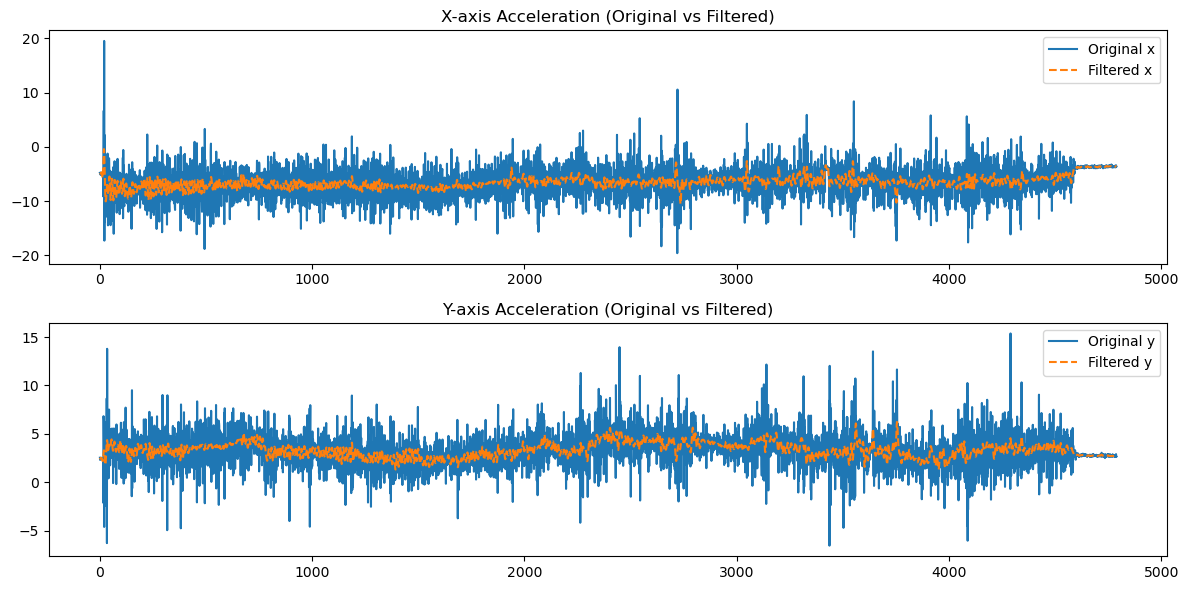

In [5]:
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# 加载数据
df = pd.read_csv("swimming_accel_data.csv")

# 滤波函数：低通滤波器
def low_pass_filter(data, cutoff_freq, sampling_rate=20, order=4):
    nyquist = 0.5 * sampling_rate  # 奈奎斯特频率
    normal_cutoff = cutoff_freq / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

# 假设采样率是20Hz，每秒采样20次
sampling_rate = 20
cutoff_freq = 2  # 低通滤波器截止频率为2Hz（可以去除高频噪声）

# 对每个加速度轴进行滤波
df['x_filtered'] = low_pass_filter(df['Accel_X'], cutoff_freq, sampling_rate)
df['y_filtered'] = low_pass_filter(df['Accel_Y'], cutoff_freq, sampling_rate)
df['z_filtered'] = low_pass_filter(df['Accel_Z'], cutoff_freq, sampling_rate)

# 可视化原始数据与滤波后的数据
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(df['Accel_X'], label='Original x')
plt.plot(df['x_filtered'], label='Filtered x', linestyle='--')
plt.legend()
plt.title('X-axis Acceleration (Original vs Filtered)')

plt.subplot(2, 1, 2)
plt.plot(df['Accel_Y'], label='Original y')
plt.plot(df['y_filtered'], label='Filtered y', linestyle='--')
plt.legend()
plt.title('Y-axis Acceleration (Original vs Filtered)')

plt.tight_layout()
plt.show()



In [6]:
# 计算标准运动模式的统计特征
# 选取滤波后的加速度数据（x_filtered, y_filtered, z_filtered）

def compute_statistics(data):
    mean = np.mean(data)
    std = np.std(data)
    min_val = np.min(data)
    max_val = np.max(data)
    return mean, std, min_val, max_val

# 计算x, y, z轴的均值、标准差、最小值和最大值
x_mean, x_std, x_min, x_max = compute_statistics(df['x_filtered'])
y_mean, y_std, y_min, y_max = compute_statistics(df['y_filtered'])
z_mean, z_std, z_min, z_max = compute_statistics(df['z_filtered'])

# 打印统计特征
print(f"X-axis: mean={x_mean}, std={x_std}, min={x_min}, max={x_max}")
print(f"Y-axis: mean={y_mean}, std={y_std}, min={y_min}, max={y_max}")
print(f"Z-axis: mean={z_mean}, std={z_std}, min={z_min}, max={z_max}")


X-axis: mean=-6.523032763607322, std=1.0777021752315656, min=-10.509479650215079, max=-0.4198278035008306
Y-axis: mean=3.311997275885903, std=0.7371511789271129, min=1.3085402858444937, max=6.231653329913571
Z-axis: mean=-4.82952034751158, std=2.4676414294235283, min=-11.453521275987866, max=1.893656032614339


In [25]:

from time import sleep

from gpiozero import Button, MCP3008
from gpiozero.tools import absoluted, scaled  # 压力传感器
from signal import pause
import math


from gpiozero import Buzzer
from gpiozero import LED      # 蜂鸣器


pressure_sign = MCP3008(channel=0)    # 定义压力传感器获取ADC值通道

makerobo_Buzzer = 17    # 有源蜂鸣器管脚定义
# GPIO设置函数 #蜂鸣器的相关函数
def makerobo_setup():
    global bz
    bz = Buzzer(pin=makerobo_Buzzer,active_high = False )  # 设置管脚，及改为低电平开启蜂鸣器
    bz.off()
#  打开蜂鸣器  蜂鸣器的相关函数
def makerobo_buzzer_on():
	bz.on()    # 蜂鸣器为低电平触发，所以使能蜂鸣器让其发声
# 关闭蜂鸣器
def makerobo_buzzer_off():
	bz.off()  # 蜂鸣器设置为高电平，关闭蜂鸟器

# 控制蜂鸣器鸣叫
def makerobo_beep(x):
	makerobo_buzzer_on()     # 打开蜂鸣器控制
	sleep(x)            # 延时时间
	makerobo_buzzer_off()    # 关闭蜂鸣器控制
	sleep(x)            # 延时时间

makerobo_setup()  # 蜂鸣器初始化


## 提取“正常”游泳数据

In [16]:
import pandas as pd
import numpy as np

# 读取游泳动作数据
data = pd.read_csv("swimming_accel_data.csv")

# 计算加速度幅值
data['accel_magnitude'] = np.sqrt(data['Accel_X']**2 + data['Accel_Y']**2 + data['Accel_Z']**2)

# 设置窗口大小为15秒，每个窗口300个数据点
window_size = 300

# 用于存储每个窗口的特征
window_features = []

# 提取每15秒窗口的特征
for start in range(0, len(data) - window_size, window_size):
    window_data = data[start:start + window_size]
    
    mean_accel = window_data['accel_magnitude'].mean()
    std_accel = window_data['accel_magnitude'].std()
    max_accel = window_data['accel_magnitude'].max()
    min_accel = window_data['accel_magnitude'].min()
    
    window_features.append([mean_accel, std_accel, max_accel, min_accel])

# 将特征转换为DataFrame
feature_df = pd.DataFrame(window_features, columns=['mean_accel', 'std_accel', 'max_accel', 'min_accel'])

# 计算标准值（均值和标准差）
standard_values = feature_df.mean()
std_devs = feature_df.std()

print("Standard values for each feature:")
print(standard_values)


Standard values for each feature:
mean_accel     9.491434
std_accel      2.775671
max_accel     19.903076
min_accel      2.491428
dtype: float64


In [17]:
print("Standard values for each feature:")
print(std_devs) 

Standard values for each feature:
mean_accel    0.141702
std_accel     0.259808
max_accel     2.679583
min_accel     0.644451
dtype: float64


In [46]:
import time
from mpu6050 import mpu6050  # 假设你使用的是这个MPU6050库

# 初始化MPU6050传感器
sensor = mpu6050(0x68)

# 设置标准值（假设已经从标准值提取部分获得）
# Standard values for each feature:
# mean_accel     9.460011
# std_accel      2.714716
# max_accel     19.540122
# min_accel      2.541039
standard_values = {
    'mean_accel': 9.460011 ,  # 这些值来自你之前提取的标准数据  9.460011
    'std_accel': 2.714716,
    'max_accel': 19.540122,
    'min_accel': 2.541039
}

std_devs = {
    'mean_accel': 0.141702,
    'std_accel': 0.259808,
    'max_accel': 2.679583,
    'min_accel': 0.644451
}

# 容忍的阈值，超过这个值即认为异常
threshold = 3

# 用于实时采集和检测数据
def get_accel_data():
    accel_data = sensor.get_accel_data()
    return accel_data['x'], accel_data['y'], accel_data['z']

def calculate_magnitude(x, y, z):
    return np.sqrt(x**2 + y**2 + z**2)

def detect_anomaly(window_data):
    # 计算特征
    mean_accel = np.mean(window_data)
    std_accel = np.std(window_data)
    max_accel = np.max(window_data)
    min_accel = np.min(window_data)
    
    # 比较与标准值的偏差
    diff_mean = abs(mean_accel - standard_values['mean_accel']) / std_devs['mean_accel']
    diff_std = abs(std_accel - standard_values['std_accel']) / std_devs['std_accel']
    diff_max = abs(max_accel - standard_values['max_accel']) / std_devs['max_accel']
    diff_min = abs(min_accel - standard_values['min_accel']) / std_devs['min_accel']
    
    # 判断是否超出阈值
    if diff_mean > threshold or diff_std > threshold or diff_max > threshold or diff_min > threshold:
        return True  # 异常
    return False  # 正常

def real_time_detection():
    ctime = 0
    window_data = []  # 存储当前15秒的数据
    alert = False
    print("开始")
    # 开始实时采样
    while True:
        # 获取传感器数据
        x, y, z = get_accel_data()  # 假设这个函数返回当前加速度数据
        magnitude = calculate_magnitude(x, y, z)  # 计算加速度的模值（也可以使用单独的x, y, z）
        window_data.append(magnitude)

        # 压力传感器相关
        if(pressure_sign.value > 0.8):
            ctime += 1
        else:
            ctime = 0

        if ctime > 200:
            alert = True
            print("ALERT! Long time in water!")
        else:
            alert = False
            
        # 当窗口数据满300个数据点时进行检测
        if len(window_data) == 300:
            if detect_anomaly(window_data):
                alert = True
                print("ALERT! Abnormal swimming motion detected!")
            else:
                alert = False
                # print("Normal swimming motion.")
            
            # 每次检测完后，窗口向前滑动，丢掉最早的数据点，准备下一轮数据
            window_data.pop(0)  # 弹出最早的一个数据点
            window_data.pop(1)  # 弹出最早的一个数据点
            window_data.pop(2)  # 弹出最早的一个数据点
            window_data.pop(3)  # 弹出最早的一个数据点
            window_data.pop(4)  # 弹出最早的一个数据点

        if alert:
            makerobo_buzzer_on()
        else:
            makerobo_buzzer_off()
        
        # 每0.05秒采集一次数据
        time.sleep(0.05)


In [53]:
cctime = 0
while True:
    if(pressure_sign.value > 0.8):
        cctime += 1
    else:
        cctime = 0
    if cctime > 10:
        break
    sleep(0.2)
# 启动实时检测
real_time_detection()


开始
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water!
ALERT! Long time in water

KeyboardInterrupt: 

In [49]:
pressure_sign.value

0.004396678065461623

In [52]:
makerobo_buzzer_off()